In [1]:
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import copy
import time
from collections import defaultdict

In [ ]:
!unzip /content/drive/MyDrive/preprocessedData.zip -d /content/drive/MyDrive/preprocessedData

Archive:  /content/drive/MyDrive/preprocessedData.zip
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79164_50956.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79126_50983.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79115_50984.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79167_50988.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79147_51017.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79170_50981.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79136_51002.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79159_50972.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/images_B/79125_50977.jpg  
  inflating: /content/drive/MyDrive/preprocessedData/preprocessedData/ima

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Paths to the dataset
DATASET_DIR = '/content/drive/MyDrive/preprocessedData'
IMAGE_SHAPE = (256, 256, 3)

# Load and preprocess data
def load_data(dataset_dir, image_shape):
    before_images, after_images, masks = [], [], []

    before_dir = os.path.join(dataset_dir, 'images_A')
    after_dir = os.path.join(dataset_dir, 'images_B')
    mask_dir = os.path.join(dataset_dir, 'masks')

    for filename in tqdm(os.listdir(before_dir)):
        if not filename.endswith('.jpg'):
            continue
        before_img = tf.keras.utils.load_img(os.path.join(before_dir, filename), target_size=image_shape[:2])
        after_img = tf.keras.utils.load_img(os.path.join(after_dir, filename), target_size=image_shape[:2])
        mask_img = tf.keras.utils.load_img(os.path.join(mask_dir, filename), target_size=image_shape[:2], color_mode='grayscale')

        before_images.append(np.array(before_img) / 255.0)
        after_images.append(np.array(after_img) / 255.0)
        masks.append(np.array(mask_img) / 255.0)

    before_images = np.array(before_images, dtype=np.float32)
    after_images = np.array(after_images, dtype=np.float32)
    masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)

    return before_images, after_images, masks


before, after, masks = load_data(DATASET_DIR, IMAGE_SHAPE)

# Split data into train and validation sets
train_before, val_before, train_after, val_after, train_masks, val_masks = train_test_split(
    before, after, masks, test_size=0.2, random_state=42
)

100%|██████████| 833/833 [10:18<00:00,  1.35it/s]


In [5]:
print("Number of A images:", len(train_before))
print("Number of B images:", len(train_after))
print("Number of label images:", len(masks))

Number of A images: 666
Number of B images: 666
Number of label images: 833


In [6]:
print(train_before.shape)
print(train_after.shape)
print(masks.shape)

(666, 256, 256, 3)
(666, 256, 256, 3)
(833, 256, 256, 1)


In [7]:
class ChangeDetectionDataset(Dataset):
    def __init__(self, A_folder, B_folder, labels_folder, transform=None):
        self.A_folder = A_folder
        self.B_folder = B_folder
        self.labels_folder = labels_folder
        self.transform = transform

        self.file_names = os.listdir(A_folder)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):

        if self.file_names[idx].endswith('.jpg'):
            file_name = self.file_names[idx]
        else:
            return self.__getitem__(idx + 1)  # Recursively try the next index

        img_A = Image.open(os.path.join(self.A_folder, file_name)).convert('RGB')  # Ensure RGB channels
        img_B = Image.open(os.path.join(self.B_folder, file_name)).convert('RGB')
        label = Image.open(os.path.join(self.labels_folder, file_name)).convert('L')

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
            label = self.transform(label)

        # Concatenate img_A and img_B along the channel dimension (dim=0 for batch)
        img_combined = torch.cat((img_A, img_B), dim=0)

        return img_combined, label

def get_data_loaders(A_folder, B_folder, labels_folder, batch_size=25, shuffle=True, num_workers=0):
    trans = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set = ChangeDetectionDataset(A_folder, B_folder, labels_folder, transform=trans)
    val_set = ChangeDetectionDataset(A_folder, B_folder, labels_folder, transform=trans)
    test_set = ChangeDetectionDataset(A_folder, B_folder, labels_folder, transform=trans)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    return dataloaders


In [8]:
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        # TODO: Define needed layers, use n_class variable in the last layer.

        # Define the encoder layers
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)  # Input channels are 6 (3 from img_A and 3 from img_B)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu8 = nn.ReLU()

        # Define the decoder layers
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.relu9 = nn.ReLU()
        self.conv10 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu10 = nn.ReLU()

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.relu11 = nn.ReLU()
        self.conv12 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu12 = nn.ReLU()

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu13 = nn.ReLU()
        self.conv14 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu14 = nn.ReLU()

        # Define the output layer
        self.conv15 = nn.Conv2d(64, n_classes, kernel_size=1)
        self.out15 = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out1 = out
        out = self.maxpool1(out)

        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out2 = out
        out = self.maxpool2(out)

        out = self.conv5(out)
        out = self.relu5(out)
        out = self.conv6(out)
        out = self.relu6(out)
        out3 = out
        out = self.maxpool3(out)

        # Base convolutional layers
        out = self.conv7(out)
        out = self.relu7(out)
        out = self.conv8(out)
        out = self.relu8(out)

        # Decoder
        out = self.upconv1(out)
        out = torch.cat((out, out3), dim=1)
        out = self.conv9(out)
        out = self.relu9(out)
        out = self.conv10(out)
        out = self.relu10(out)

        out = self.upconv2(out)
        out = torch.cat((out, out2), dim=1)
        out = self.conv11(out)
        out = self.relu11(out)
        out = self.conv12(out)
        out = self.relu12(out)

        out = self.upconv3(out)
        out = torch.cat((out, out1), dim=1)
        out = self.conv13(out)
        out = self.relu13(out)
        out = self.conv14(out)
        out = self.relu14(out)
        out = self.conv15(out)
        out_mask = self.out15(out)

        return out

In [9]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def jaccard_index(pred, target):
    intersection = torch.sum(pred * target, dim=(2, 3))
    union = torch.sum(pred, dim=(2, 3)) + torch.sum(target, dim=(2, 3)) - intersection
    jaccard_per_image = torch.where(union == 0, torch.tensor(1.0), (intersection + 1e-10) / (union + 1e-10))
    return torch.mean(jaccard_per_image, dim=1)

def calc_loss(pred, target, metrics, bce_weight=0.8):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    jaccard_per_image = jaccard_index((pred > 0.5).float(), target)
    jaccard = torch.mean(jaccard_per_image)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    metrics['bce'] += bce.data.to("cuda:0") * target.size(0)
    metrics['dice'] += dice.data.to("cuda:0") * target.size(0)
    metrics['jaccard'] += jaccard.to("cuda:0") * target.size(0)
    metrics['loss'] += loss.data.to("cuda:0") * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    if phase != 'test':
        outputs.append("Jaccard Index: {:4f}".format(metrics['jaccard'] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, dataloaders, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs_combined, labels in dataloaders[phase]:
                inputs_combined = inputs_combined.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs_combined)
                    loss = calc_loss(outputs, labels, metrics)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_samples += inputs_combined.size(0)

            if phase == 'train':
                scheduler.step()

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)
    return model

In [11]:
# Define paths to your folders
A_folder = '/content/drive/MyDrive/preprocessedData/images_A'
B_folder = '/content/drive/MyDrive/preprocessedData/images_B'
labels_folder = '/content/drive/MyDrive/preprocessedData/masks'

# Define batch size and other parameters
batch_size = 16
shuffle = True
num_workers = 2
num_epochs = 50

# Get data loaders
dataloaders = get_data_loaders(A_folder, B_folder, labels_folder, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Define model
model = UNet(n_classes=1)  # Define number of classes appropriately




In [12]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Train the model
trained_model = train_model(model, optimizer, scheduler, dataloaders, num_epochs=num_epochs)

Epoch 0/49
----------
train: bce: 0.327062, dice: 0.950512, jaccard: 0.000000, loss: 0.451752, Jaccard Index: 0.000000
val: bce: 0.236419, dice: 0.946715, jaccard: 0.000000, loss: 0.378478, Jaccard Index: 0.000000
saving best model
0m 48s
Epoch 1/49
----------
train: bce: 0.225462, dice: 0.952369, jaccard: 0.000000, loss: 0.370843, Jaccard Index: 0.000000
val: bce: 0.218332, dice: 0.955774, jaccard: 0.000000, loss: 0.365820, Jaccard Index: 0.000000
saving best model
0m 46s
Epoch 2/49
----------
train: bce: 0.216798, dice: 0.947212, jaccard: 0.000000, loss: 0.362881, Jaccard Index: 0.000000
val: bce: 0.213758, dice: 0.936627, jaccard: 0.000000, loss: 0.358332, Jaccard Index: 0.000000
saving best model
0m 47s
Epoch 3/49
----------
train: bce: 0.214433, dice: 0.937993, jaccard: 0.000000, loss: 0.359145, Jaccard Index: 0.000000
val: bce: 0.222327, dice: 0.957503, jaccard: 0.000000, loss: 0.369363, Jaccard Index: 0.000000
0m 47s
Epoch 4/49
----------
train: bce: 0.215488, dice: 0.936447, ja

In [13]:
#save best model
torch.save(trained_model.state_dict(), '/content/drive/MyDrive/best_model_unet_50ep.pth')


In [16]:
#eval model
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_unet_50ep.pth'))
model.eval()

<ipython-input-16-821afe4c6d79>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_unet_50ep.pth'))


UNet(
  (conv1): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu7): ReLU()
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride

In [17]:
# inference model to get change detection mask

def inference(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    outputs = []
    labels = []
    with torch.no_grad():
        for inputs_combined, label in dataloader:
            inputs_combined = inputs_combined.to(device)
            label = label.to(device)
            output = model(inputs_combined)
            outputs.append(output.cpu())
            labels.append(label.cpu())
    return torch.cat(outputs), torch.cat(labels)

pred_mask,label_mask = inference(model, dataloaders['test'])




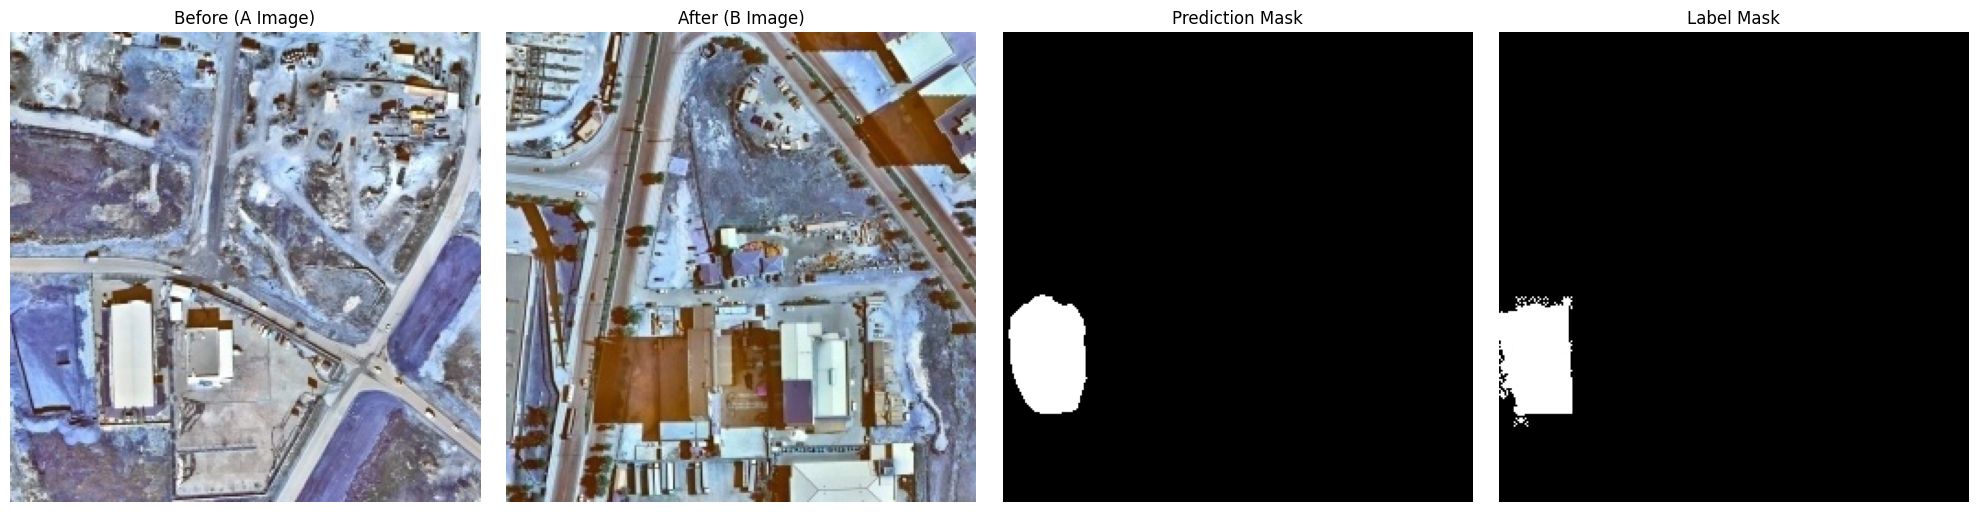

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_results(img_A_path, img_B_path, pred_mask, label_mask):
    """
    Yan yana görselleştirme yapar:
    - Önceki görüntü (Before)
    - Sonraki görüntü (After)
    - Tahmin maskesi ve Gerçek maskesi
    """
    # Eşikleme uygulama
    threshold = 0.5
    binary_mask = (pred_mask.cpu().numpy() > threshold).astype(np.uint8)  # 0 ve 1 arasında eşik uygular

    # Görselleştirme için bir grid oluştur
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 satır, 4 sütun

    # Before (A Image) - Load image from path
    img_A = Image.open(img_A_path).convert('RGB')
    img_A = np.array(img_A)
    axes[0].imshow(img_A)  # RGB görüntüyü göster
    axes[0].set_title("Before (A Image)")
    axes[0].axis('off')

    # After (B Image) - Load image from path
    img_B = Image.open(img_B_path).convert('RGB')
    img_B = np.array(img_B)
    axes[1].imshow(img_B)  # RGB görüntüyü göster
    axes[1].set_title("After (B Image)")
    axes[1].axis('off')

    # Tahmin Maskesi (Prediction)
    axes[2].imshow(binary_mask.squeeze(), cmap='gray')  # Binary mask için gri tonlama
    axes[2].set_title("Prediction Mask")
    axes[2].axis('off')

    # Gerçek Maskesi (Label)
    axes[3].imshow(label_mask.squeeze(), cmap='gray')  # Binary mask için gri tonlama
    axes[3].set_title("Label Mask")
    axes[3].axis('off')



    # Grafikleri göster
    plt.tight_layout()
    plt.show()

# Get a list of image paths from your folders
A_image_paths = [os.path.join(A_folder, filename) for filename in os.listdir(A_folder) if filename.endswith('.jpg')]
B_image_paths = [os.path.join(B_folder, filename) for filename in os.listdir(B_folder) if filename.endswith('.jpg')]

# Visualize results for the first image pair
visualize_results(A_image_paths[0], B_image_paths[0], pred_mask[0], label_mask[0])